## Testing PyTorch with MNIST Fashion dataset
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### Get PyTorch and MNIST Data

In [115]:
# Packages
# import tensorflow as tf
# from tensorflow import keras
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [116]:
# Get the training and testing data sets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

### Show some samples and extract feature/label data

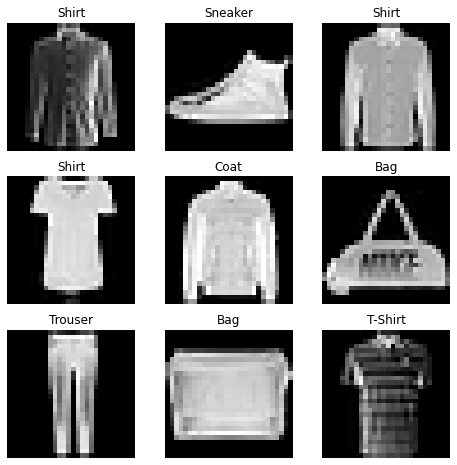

In [117]:
# Labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Create a 3x3 plot with random samples and labels
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


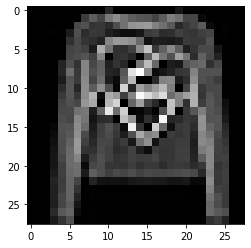

Label: 2


In [118]:
# Put the data into dataloaders for PyTorch
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

# Show a sample from the data along with shape info
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Create the Neural Net

In [8]:
# Ensures use of hardware accelerator, like a gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Using {device} device')

Using cpu device


In [9]:
# Build a Neural Network to classify the MNISTFashion set
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Predicted class: Ankle Boot


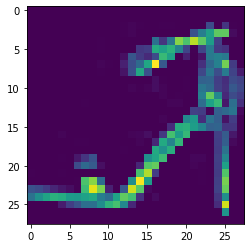

In [27]:
# Run the NN as is on random input
# X = torch.rand(1, 28, 28, device=device)
X = training_data[8][0]

plt.imshow(X.squeeze())

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {labels_map[y_pred.item()]}")

### Train the Model

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
# Functions to train and test the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
# Run a certain number of epochs for the training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304609  [    0/60000]
loss: 2.287953  [ 6400/60000]
loss: 2.279060  [12800/60000]
loss: 2.254281  [19200/60000]
loss: 2.258276  [25600/60000]
loss: 2.244633  [32000/60000]
loss: 2.213454  [38400/60000]
loss: 2.200533  [44800/60000]
loss: 2.184701  [51200/60000]
loss: 2.166764  [57600/60000]
Test Error: 
 Accuracy: 43.9%, Avg loss: 2.162245 

Epoch 2
-------------------------------
loss: 2.136911  [    0/60000]
loss: 2.131265  [ 6400/60000]
loss: 2.123271  [12800/60000]
loss: 2.125921  [19200/60000]
loss: 2.081898  [25600/60000]
loss: 2.049995  [32000/60000]
loss: 2.014256  [38400/60000]
loss: 1.986897  [44800/60000]
loss: 1.931255  [51200/60000]
loss: 1.915712  [57600/60000]
Test Error: 
 Accuracy: 59.6%, Avg loss: 1.903732 

Epoch 3
-------------------------------
loss: 1.901348  [    0/60000]
loss: 1.842403  [ 6400/60000]
loss: 1.807950  [12800/60000]
loss: 1.787459  [19200/60000]
loss: 1.711752  [25600/60000]
loss: 1.642656  [32000/600

### How does the model do?

In [95]:
# Confusion Matrix from HW2
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [134]:
model.eval()   # Make sure model is in eval mode

# Collect various pieces of data
label_set = np.unique(test_labels)
pred_lab = np.array([])
pred_prob = np.array([])
test_labels = np.array([])
label_names = np.array([labels_map[i] for i in label_set])

# Run the model over all test data
with torch.no_grad():
    for X, y in test_dataloader:
        pred = nn.Softmax(dim=1)(model(X))
        pred_lab = np.append(pred_lab, pred.argmax(1).tolist())
        pred_prob = np.append(pred_prob, [max(probs) for probs in pred.tolist()])
        test_labels = np.append(test_labels, y.tolist())


Confusion matrix, without normalization
[[777   4  10  94  14   1  81   2  17   0]
 [ 30 906  12  38  11   0   0   0   3   0]
 [ 15   0 633  11 258   0  56   0  27   0]
 [105 139   5 670  30   0  47   0   4   0]
 [ 18   8 299  75 569   0  15   0  16   0]
 [  1   0   1   2   0  22   0 513  15 446]
 [250   5 271  50 279   0  89   0  56   0]
 [  0   0   0   0   0   0   0 904   1  95]
 [  7   2  18  21  10   1  10  22 906   3]
 [  1   0   0   1   0   0   1  77   1 919]]


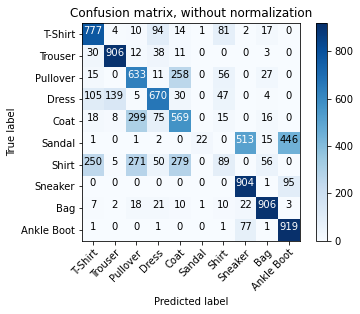

In [135]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_labels, pred_lab)
label_set = np.unique(test_labels)
plot_confusion_matrix(cnf_matrix, label_names,
                      title='Confusion matrix, without normalization')

In [136]:
# Confusion Matrix with pictures from HW2
import matplotlib.image as mpimg
def gen_err_predicted_fig( data, test_labels, pred_lab, pred_prob, label_set, label_names, figsize=(10, 10)):
    errNameMap = {}
    maxErrNameMap = {}
    cnt = 0
    for lab in label_set:
        for plab in label_set:
            if lab == plab:
                continue
            else:
                cIdx = np.nonzero(test_labels==lab)[0]
                errIdx = cIdx[ np.nonzero(pred_lab[cIdx]==plab)[0] ]
                errNameMap[(lab, plab)] = errIdx
                if len(errIdx) != 0:
                    errProb = np.max( pred_prob[errIdx] )
                    errFIdx = errIdx[ np.argmax( pred_prob[errIdx] ) ]
                    maxErrNameMap[(lab, plab)] = errFIdx
    title_font = {'fontname':'Arial', 'size':'16', 
                  'color':'black', 'weight':'bold'} 
    fig = plt.figure(figsize=figsize)
    num = len(label_set)
    for i in range(num*num):
        rIdx = i // num
        cIdx = i % num
        ax = plt.subplot(num, num, i+1)
        if rIdx == 0:
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel( label_names[int(label_set[cIdx])], 
                           rotation=45, rotation_mode='anchor', ha = 'left' )
        if cIdx == 0:
            ax.yaxis.set_label_position('left')
            ax.set_ylabel( label_names[int(label_set[rIdx])],  
                           rotation=45, rotation_mode='anchor', ha = 'right' )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(wspace=0, hspace=0)
        
        if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
            fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]    
            plt.imshow(data[fIdx][0].squeeze())
        else:
            plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
                     **title_font)
        
#         if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
#             fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]            
#             folderName = label_names[test_labels[fIdx]]            
#             fID = test_sample_ids[fIdx]
#             img=mpimg.imread( srcPath + '/' + folderName.decode('utf-8') + '/' + \
#                              fID.decode('utf-8') + '.jpg')    
#             plt.imshow(img)  # The AxesGrid object work as a list of axes.
#         else:
#             plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
#                      **title_font)
    
    plt.show()

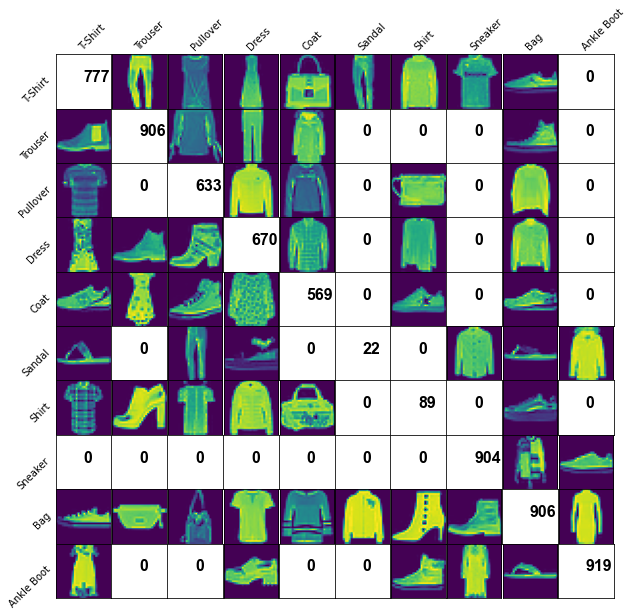

In [137]:

# print(label_set)
# print(pred_lab)
gen_err_predicted_fig( test_data, test_labels, pred_lab, pred_prob, label_set, label_names)